# Predict a US presidential election using Bayesian optimal polling

In this tutorial, we explore the use of optimal experimental design techniques to create an optimal polling strategy to predict the outcome of the US presidential election. We take the 2012 election as our prior and the 2016 election as our test set: we imagine that we are conducting polling just before the 2016 election.

## The model
For each of the 50 states we define 

$$ \text{logit }\mathbb{P}(\text{a random voter in state } i \text{ votes Democrat in the 2016 election}) = \theta_i $$

and we assume all other voters vote Republican. Right before the election, the value of $\theta$ is unknown and we wish to estimate it using polling. The winner $w$ of the election is decided by the Electoral College system. The number of electoral college votes gained by the Democrats in state $i$ is
$$
e_i =  \begin{cases}
k_i \text{ if } \theta_i > \frac{1}{2} \\
0 \text{ otherwise}
\end{cases}
$$
(this is a rough approximation of the true system). All other electoral college votes go to the Republicans. Here $k_i$ is the number of electoral college votes alloted to state $i$, which are listed in the following data frame.

In [1]:
import pandas as pd
import torch

electoral_college_votes = pd.read_pickle("electoral_college_votes.pickle")
print(electoral_college_votes)
ec_votes_tensor = torch.tensor(electoral_college_votes.values, dtype=torch.float).squeeze()

       Electoral college votes
State                         
AL                           9
AK                           3
AZ                          11
AR                           6
CA                          55
CO                           9
CT                           7
DE                           3
DC                           3
FL                          29
GA                          16
HI                           4
ID                           4
IL                          20
IN                          11
IA                           6
KS                           6
KY                           8
LA                           8
ME                           4
MD                          10
MA                          11
MI                          16
MN                          10
MS                           6
MO                          10
MT                           3
NE                           5
NV                           6
NH                           4
NJ      

The winner $w$ of the election is

$$ w = \begin{cases}
\text{Democrats if } \sum_i e_i > \frac{1}{2}\sum_i k_i  \\
\text{Republicans otherwise}
\end{cases}
$$

We are interested in polling strategies that will help us predict $w$, rather than predicting the more complex state-by-state results $\theta$.

To set up a fully Bayesian model, we need a prior for $\theta$. We will base the prior on the outcome of some historical presidential elections. Specifically, we'll use the following dataset of state-by-state election results for the presidential elections 1976-2012 inclusive. Note that votes for parties other than Democrats and Republicans have been ignored.

In [2]:
frame = pd.read_pickle("us_presidential_election_data_historical.pickle")
print(frame)

          1976                1980                1984                1988  \
      Democrat Republican Democrat Republican Democrat Republican Democrat   
State                                                                        
AL      659170     504070   636730     654192   551899     872849   549506   
AK       44058      71555    41842      86112    62007     138377    72584   
AZ      295602     418642   246843     529688   333854     681416   454029   
AR      499614     268753   398041     403164   338646     534774   349237   
CA     3742284    3882244  3083661    4524858  3922519    5467009  4702233   
CO      460353     584367   367973     652264   454974     821818   621453   
CT      647895     719261   541732     677210   569597     890877   676584   
DE      122596     109831   105754     111252   101656     152190   108647   
DC      137818      27873   130231      23313   180408      29009   159407   
FL     1636000    1469531  1419475    2046951  1448816    273035

Based on this data alone, we will base our prior mean for $\theta$ solely on the 2012 election. Specifically, we'll choose a prior mean as follows:

In [3]:
results_2012 = torch.tensor(frame[2012].values, dtype=torch.float)
prior_mean = torch.log(results_2012[..., 0] / results_2012[..., 1])
print(prior_mean)

tensor([-0.4564, -0.2947, -0.1851, -0.4961,  0.4842,  0.1100,  0.3546,  0.3825,
         2.5250,  0.0177, -0.1586,  0.9298, -0.6821,  0.3465, -0.2088,  0.1185,
        -0.4521, -0.4702, -0.3535,  0.3170,  0.5460,  0.4805,  0.1926,  0.1580,
        -0.2331, -0.1917, -0.2832, -0.4528,  0.1365,  0.1135,  0.3634,  0.2126,
         0.5884, -0.0414, -0.4104,  0.0606, -0.6979,  0.2522,  0.1094,  0.5761,
        -0.2131, -0.3730, -0.4201, -0.3231, -1.0788,  0.7652,  0.0787,  0.3075,
        -0.5613,  0.1409, -0.9032])


Our prior distribution for $\theta$ will be a multivariate Normal with mean `prior_mean`. The only thing left to decide upon is the covariance matrix.

*Aside*: The prior covariance is important in a number of ways. If we allow too much variance, the prior will be uncertain about the outcome in every state, and require polling everywhere. If we allow too little variance, we may be caught off-guard by an unexpected electoral outcome. If we assume states are independent, then we will not be able to pool information across states; but assume too much correlation and we could too faithfully base predictions about one state from poll results in another.

We select the prior covariance by taking the empirical covariance from the elections 1976 - 2012 and adding a small value `0.01` to the diagonal.

In [4]:
idx = 2 * torch.arange(10)
as_tensor = torch.tensor(frame.values, dtype=torch.float)
logits = torch.log(as_tensor[..., idx] / as_tensor[..., idx + 1]).transpose(0, 1)
mean = logits.mean(0)
sample_covariance = (1/(logits.shape[0] - 1)) * (
    (logits.unsqueeze(-1) - mean) * (logits.unsqueeze(-2) - mean)
).sum(0)
prior_covariance = sample_covariance + 0.01 * torch.eye(sample_covariance.shape[0])
# prior_covariance = 0.05 * torch.eye(51) + 0.03 * torch.ones(51, 51)

In [5]:
std = prior_covariance.diag().sqrt()
theoretical = pd.DataFrame({"State": frame.index, 
                            "Min theta": torch.sigmoid(prior_mean - 2 * std), 
                            "Max theta": torch.sigmoid(prior_mean + 2 * std)}).set_index("State")
print(theoretical)

       Max theta  Min theta
State                      
AL      0.520270   0.270133
AK      0.531208   0.328617
AZ      0.596407   0.318507
AR      0.580075   0.211602
CA      0.759051   0.455326
CO      0.664190   0.386520
CT      0.732970   0.425410
DE      0.729813   0.443066
DC      0.963292   0.856023
FL      0.640957   0.367225
GA      0.638424   0.291993
HI      0.850761   0.529729
ID      0.454923   0.234430
IL      0.713572   0.445285
IN      0.544537   0.355222
IA      0.624781   0.432204
KS      0.489936   0.296526
KY      0.507059   0.275158
LA      0.542533   0.293683
ME      0.718350   0.425010
MD      0.739448   0.512244
MA      0.743183   0.474608
MI      0.667361   0.422860
MN      0.616234   0.460671
MS      0.543425   0.345158
MO      0.558177   0.350411
MT      0.553832   0.313746
NE      0.504112   0.284559
NV      0.711678   0.347392
NH      0.710745   0.338036
NJ      0.732755   0.430012
NM      0.679106   0.419590
NY      0.770537   0.491388
NC      0.601656   0

We are now in a position to define our Bayesian model.

In [6]:
from contextlib import ExitStack

import pyro
import pyro.distributions as dist
from pyro.contrib.util import iter_plates_to_shape

def model(polling_allocation):
    with ExitStack() as stack:
        for plate in iter_plates_to_shape(polling_allocation.shape[:-1]):
            stack.enter_context(plate)
        theta = pyro.sample("theta", dist.MultivariateNormal(prior_mean, covariance_matrix=prior_covariance))
        poll_results = pyro.sample("y", dist.Binomial(polling_allocation, logits=theta).to_event(1))
        dem_win_state = (theta > 0.).float()
        dem_electoral_college_votes = ec_votes_tensor * dem_win_state
        dem_win = (dem_electoral_college_votes.sum(-1) / ec_votes_tensor.sum(-1) > .5).float()
        pyro.sample("w", dist.Delta(dem_win))
        return poll_results, dem_win, theta

This Bayesian model implicitly defines our prior on `w`. We can investigate this prior by simulating many times from our prior.

In [7]:
_, dem_wins, theta_samples = model(torch.ones(100000, 51))
prior_w_prob = dem_wins.float().mean()
print("Prior probability of Dem win", prior_w_prob.item())

Prior probability of Dem win 0.6819300055503845


We can also investigate which states, a priori, are most marginal.

In [8]:
dem_prob = (theta_samples > 0.).float().mean(0)
marginal = torch.argsort((dem_prob - .5).abs()).numpy()
prior_prob_dem = pd.DataFrame({"State": frame.index[marginal],
                               "Democrat win probability": dem_prob.numpy()[marginal]}).set_index('State')
print(prior_prob_dem)

       Democrat win probability
State                          
FL                      0.52710
NC                      0.42669
NH                      0.61747
OH                      0.62372
VA                      0.63728
NV                      0.64134
CO                      0.64999
GA                      0.33169
IA                      0.72863
PA                      0.73914
AZ                      0.25963
MI                      0.77833
NM                      0.78791
WI                      0.79002
SC                      0.20418
MO                      0.18207
MN                      0.84025
ME                      0.84811
IN                      0.14028
CT                      0.86083
MT                      0.12802
NJ                      0.87251
OR                      0.87329
MS                      0.12640
WA                      0.88686
AR                      0.11174
IL                      0.89033
DE                      0.89508
LA                      0.08761
AK      

This is a sanity check, and seems to accord with our intuitions. Since our prior is based on 2012 and the Democrats won in 2012, it makes sense that we would favour a Democrat win in 2016 (this is before we have seen *any* polling data or incorporated any other information). Florida is frequently an important swing state and is top of our list of marginal states under the prior. We can also see states such as Pennsylvania and Wisconsin near the top of the list -- we know that these were instrumental in the 2016 election. (This kind of posthoc analysis is, of course, very bad and only engaged in by immoral persons.)

### Regional correlations

Finally, we take a closer look at our prior covariance. Specifically, we examine states that we expect to be more or less correlated.

In [9]:
import numpy as np


def correlation(cov):
    return cov / np.sqrt(np.expand_dims(np.diag(cov.values), 0) * np.expand_dims(np.diag(cov.values), 1))
                

new_england_states = ['ME', 'VT', 'NH', 'MA', 'RI', 'CT']
cov_as_frame = pd.DataFrame(prior_covariance.numpy(), columns=frame.index).set_index(frame.index)
ne_cov = cov_as_frame.loc[new_england_states, new_england_states]
ne_corr = correlation(ne_cov)
print(ne_corr)

State        ME        VT        NH        MA        RI        CT
State                                                            
ME     1.000000  0.817323  0.857351  0.800276  0.822024  0.825383
VT     0.817323  1.000000  0.834723  0.716342  0.754026  0.844140
NH     0.857351  0.834723  1.000000  0.871370  0.803803  0.873496
MA     0.800276  0.716342  0.871370  1.000000  0.813665  0.835148
RI     0.822024  0.754026  0.803803  0.813665  1.000000  0.849644
CT     0.825383  0.844140  0.873496  0.835148  0.849644  1.000000


In [10]:
southern_states = ['LA', 'MS', 'AL', 'GA', 'SC']
southern_cov = cov_as_frame.loc[southern_states, southern_states]
southern_corr = correlation(southern_cov)
print(southern_corr)

State        LA        MS        AL        GA        SC
State                                                  
LA     1.000000  0.554020  0.651511  0.523784  0.517672
MS     0.554020  1.000000  0.699459  0.784371  0.769198
AL     0.651511  0.699459  1.000000  0.829908  0.723015
GA     0.523784  0.784371  0.829908  1.000000  0.852818
SC     0.517672  0.769199  0.723015  0.852818  1.000000


These correlation matrices show that, as expected, logical groupings of states tend to have similar voting trends.

In [11]:
cross_cov = cov_as_frame.loc[new_england_states + southern_states, new_england_states + southern_states]
cross_corr = correlation(cross_cov)
print(cross_corr.loc[new_england_states, southern_states])

State        LA        MS        AL        GA        SC
State                                                  
ME     0.329438  0.309352 -0.000534  0.122375  0.333679
VT    -0.036079  0.009653 -0.366604 -0.202065  0.034438
NH     0.234105  0.146826 -0.105781  0.008411  0.233084
MA     0.338411  0.122257 -0.059107 -0.025730  0.182290
RI     0.314088  0.188819 -0.066307 -0.022142  0.186955
CT     0.139021  0.074646 -0.205797 -0.107684  0.125023


Finally, to check the data that led to these values, here is a scatter plot comparing Alabama with 1) South Carolina, 2) Connecticut

In [12]:
import matplotlib.pyplot as plt

data = (logits - mean)[...,[0,6,40]].numpy()
x, y = data[..., 0], data[..., 2]
plt.scatter(x, y)
plt.xlabel("AL")
plt.ylabel("SC")
plt.show()

<Figure size 640x480 with 1 Axes>

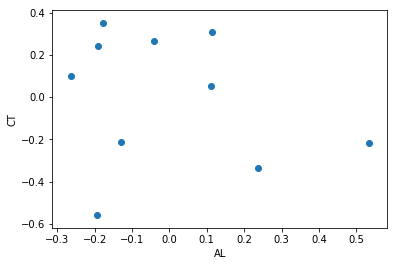

In [13]:
x, y = data[..., 0], data[..., 1]
plt.scatter(x, y)
plt.xlabel("AL")
plt.ylabel("CT")
plt.show()

## Measuring the expected information gain of a polling strategy
The prior we have set up appears to accord, at least approximately, with intuition. However, we now want to add a second source of information from polling. We aim to use our prior to select a polling strategy that will be most informative about our target $w$. A polling strategy, in this simplified set-up, is the number of people to poll in each state. (We ignore any other covariates such as regional variation inside states, demographics, etc.) We might imagine that polling 1000 people in Florida (the most marginal state), will be much more effective than polling 1000 people in Hawaii (the least marginal state). That's because the outcome in Hawaii is already quite predictable, just based on our prior, whereas the outcome in Florida is really up for grabs.

In fact, the information that our model will gain about $w$ based on conducting a poll with design $d$ and getting outcome $y$ can be described mathematically as follows:

$$\text(IG)(d, y) = KL(p(w|y,d)||p(w))$$

Since the outcome of the poll is at present unknown, we consider the expected information gain

$$\text{EIG}(d) = \mathbb{E}_{p(y|d)}\quad[KL(p(w|y,d)||p(w))]$$.

To estimate the EIG, we make use of the following variational representation

$$\text{EIG}(d) = \max_q \mathbb{E}_{p(w, y|d)}\quad\left[\log q(w|y,d) \right] + H(p(w))$$

What is $q$? It is a machine that takes as input $y$ and outputs a distribution over $w$. Since $w$ is a binary random variable, we can think of $q$ as a classifier that tries to decide, based on the poll outcome, who the eventual winner of the election will be. In this notebook, $q$ will be a neural classifier.

In [14]:
from torch import nn

class OutcomePredictor(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(51, 256)
        self.lin2 = nn.Linear(256, 256)
        self.lin3 = nn.Linear(256, 256)
        self.lin4 = nn.Linear(256, 1)
        
    def compute_dem_probability(self, y):
        y = nn.functional.relu(self.lin1(y))
        y = nn.functional.relu(self.lin2(y))
        y = nn.functional.relu(self.lin3(y))
        return self.lin4(y)
    
    def forward(self, y_dict, design, observation_labels, target_labels):

        pyro.module("posterior_guide", self)
        
        y = y_dict["y"]
        dem_prob = self.compute_dem_probability(y).squeeze()
        pyro.sample("w", dist.Bernoulli(logits=dem_prob))

In [15]:
poll_in_florida = torch.zeros(51)
poll_in_florida[9] = 1000

In [16]:
from pyro.contrib.oed.eig import posterior_eig
from pyro.optim import Adam

pyro.clear_param_store()
guide = OutcomePredictor()
ape_florida = posterior_eig(model, poll_in_florida, "y", "w", 10, 10000, guide, 
                            Adam({"lr": 0.001}), eig=False, final_num_samples=10000)

In [17]:
def h(p):
    return -p*p.log() - (1-p)*(1-p).log()

prior_entropy = h(prior_w_prob)
eig_florida = prior_entropy - ape_florida
print("FL EIG", eig_florida.item())

FL EIG 0.2886720597743988


In [18]:
poll_in_hawaii = torch.zeros(51)
poll_in_hawaii[11] = 1000

In [19]:
pyro.clear_param_store()
ape_hawaii = posterior_eig(model, poll_in_hawaii, "y", "w", 10, 10000, guide, 
                           Adam({"lr": 0.001}), eig=False, final_num_samples=10000)

In [20]:
print("HI EIG", (prior_entropy - ape_hawaii).item())

HI EIG 0.14668723940849304


In [21]:
print("Theoretical maximum EIG", prior_entropy.item())

Theoretical maximum EIG 0.6254061460494995


Already we have established that it's better to do all our polling in Florida than in Hawaii.

In [22]:
uniform_poll = 19 * torch.ones(51)

pyro.clear_param_store()
ape_uniform = posterior_eig(model, uniform_poll, "y", "w", 10, 10000, guide, 
                            Adam({"lr": 0.001}), eig=False, final_num_samples=10000)

In [23]:
print("Uniform EIG", (prior_entropy - ape_uniform).item())

Uniform EIG 0.3293553292751312


This is surprisingly high: we have almost halved our uncertainty by polling just 19 people per state. (19 = 1000 / 51)

Where is our neural network getting its information from?

In [24]:
middle = (uniform_poll * torch.sigmoid(prior_mean)).round()
print(torch.sigmoid(guide.compute_dem_probability(middle)))

tensor([0.7149], grad_fn=<SigmoidBackward>)


In [25]:
high_in_fl = middle.clone()
high_in_fl[9] = 19
print(torch.sigmoid(guide.compute_dem_probability(high_in_fl)))

tensor([0.9007], grad_fn=<SigmoidBackward>)


In [26]:
low_in_fl = middle.clone()
low_in_fl[9] = 0
print(torch.sigmoid(guide.compute_dem_probability(low_in_fl)))

tensor([0.3752], grad_fn=<SigmoidBackward>)


In [27]:
high_in_hi = middle.clone()
high_in_hi[11] = 19
print(torch.sigmoid(guide.compute_dem_probability(high_in_hi)))

tensor([0.7936], grad_fn=<SigmoidBackward>)


In [28]:
low_in_hi = middle.clone()
low_in_hi[11] = 0
print(torch.sigmoid(guide.compute_dem_probability(low_in_hi)))

tensor([0.4312], grad_fn=<SigmoidBackward>)


In [29]:
higher_everywhere = (1 + middle.clone()).clamp(max=19)
print(torch.sigmoid(guide.compute_dem_probability(higher_everywhere)))

tensor([0.9825], grad_fn=<SigmoidBackward>)


In [30]:
lower_everywhere = (-1 + middle.clone()).clamp(min=0)
print(torch.sigmoid(guide.compute_dem_probability(lower_everywhere)))

tensor([0.1004], grad_fn=<SigmoidBackward>)


In [32]:
middle.requires_grad = True
if middle.grad:
    middle.grad.zero_()
f_middle = guide.compute_dem_probability(middle)
f_middle.backward()
middle_grad = pd.DataFrame({"State": frame.index, "Logit grad": middle.grad}).set_index("State")
print(middle_grad)

       Logit grad
State            
AL       0.023785
AK       0.038992
AZ       0.068724
AR       0.072842
CA       0.094376
CO       0.082956
CT       0.091433
DE       0.122040
DC      -0.146900
FL       0.142856
GA       0.082021
HI       0.085431
ID       0.050495
IL       0.078119
IN       0.060262
IA       0.018630
KS       0.038479
KY       0.009849
LA       0.028290
ME       0.102746
MD       0.060905
MA       0.074507
MI       0.063029
MN       0.028000
MS       0.018707
MO       0.031959
MT       0.035080
NE       0.047318
NV       0.149910
NH       0.163455
NJ       0.100571
NM       0.093218
NY       0.064132
NC       0.077044
ND       0.069025
OH       0.089014
OK       0.046468
OR       0.041256
PA       0.063324
RI       0.058838
SC       0.066554
SD       0.038139
TN       0.018970
TX       0.051673
UT       0.063991
VT       0.105317
VA       0.120077
WA       0.051245
WV      -0.010732
WI       0.042306
WY       0.041388


And finally, what about the gradient with respect to $d$?

In [33]:
from pyro.contrib.oed.differentiable_eig import _differentiable_posterior_loss

ImportError: No module named 'pyro.contrib.oed.differentiable_eig'

## Running the experiment
To run the experiment, we sample a polling outcome using the probabilities implied by the actual results from the 2016 election.


In [ ]:
test_data = pd.read_pickle("us_presidential_election_data_test.pickle")
results_2016 = torch.tensor(test_data.values, dtype=torch.float)
true_theta = torch.log(results_2016[..., 0] / results_2016[..., 1])
print(true_theta)

In [ ]:
conditioned_model = pyro.condition(model, data={"theta": true_theta})
y, _, _ = conditioned_model(uniform_poll.expand(10000, 51))

Under these 10000 hypothetical outcomes of running that same poll, how many times would our $q$ network have gone on to predict the correct electoral outcome?

In [ ]:
(guide.compute_dem_probability(y) < 0.).float().mean()

This suggests that with just 1000 accurate poll records, we may have begun to predict the outcome of the 2016 election with some confidence.